# MLP-VAE for observable population dynamics with random background
Author: Zhengqing Zhou
Updated: 2025/06/13

In this notebook, we construct VAE-MLP models to map the randomized initial conditions to the observable dynamics

In [ ]:
# We begin by importing the essentials
import numpy as np
import matplotlib.pyplot as plt

# We also setup torch for later usage.
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import trange
from torch.nn import functional as F
from torch import nn

from sklearn.metrics import r2_score

# Configure GPU if available
if torch.cuda.is_available():

    device = "cuda:0"
else:
    device = "cpu"

display(device)

## VAE Network
The VAE network has 32 channels in the encoder, consisting of 3 convolutional layers, each followed by a leaky relu function, with kernel = 3, strid = 1, and padding = 1, so the time series (length of 50) will not get shortened during the convolutions; 1 fully connected linear layer; and another two parallel linear layers to project the encoded time series to the mean value and var of the latent dimension, based on which a gaussian sampling will be done, generating the embedding of the data. The embedding is further decoded by a decoder of the symmetrical structure.

# MLP model for 10-member community

In [2]:
class VAE(nn.Module):

    def __init__(self, n_target, latent_dim):
        # Call parent model constructor and store hidden state variables.
        super().__init__()
        self.latent_dim = latent_dim
        self.n_target = n_target
        self.T = 50
        self.channels = 32

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=self.n_target, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
        )

        self.mean_map = nn.Linear(self.channels * self.T, self.latent_dim)

        self.std_map = nn.Linear(self.channels * self.T, self.latent_dim)

        self.fc_decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.channels * self.T),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.n_target, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU()
        )

    def sample(self, mean, log_var):
        """Sample a given N(0,1) normal distribution given a mean and log of variance."""

        # First compute the variance from the log variance.
        var = torch.exp(0.5 * log_var)

        # Compute a scaled distribution
        eps = torch.randn_like(var)

        # Add the vectors
        z = mean + var * eps

        return z

    def forward(self, X):
        """Forward propogate through the model, return both the reconstruction and sampled mean and standard deviation
        for the system.
        """
        pre_code = self.encoder(X)
        B, C, L = pre_code.shape
        flattened = pre_code.view(B, C * L)

        mu = self.mean_map(flattened)
        log_var = self.std_map(flattened)

        code = self.sample(mu, log_var)

        # Pass through FC layers before decoding
        post_code = self.fc_decoder(code)

        X_hat = self.decoder(post_code.view(B, C, L))

        return X_hat, code, mu, log_var

In [3]:
class MLP_VAE(torch.nn.Module):
    
    def __init__(self, VAE, n_embedding, N):
        super().__init__()
        
        self.channels = 32
        
        self.mlp = nn.Sequential(
            nn.Linear(N,self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels,self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels,n_embedding),
            nn.LeakyReLU(),
        )

        self.fc_decoder = VAE.fc_decoder.eval()
        self.decoder = VAE.decoder.eval()
        
        # Freeze the parameters of the VAE
        for param in self.fc_decoder.parameters():
            param.requires_grad = False
        for param in self.decoder.parameters():
            param.requires_grad = False
        
    
    def forward(self, X):

        B = X.shape[0]
        C = 32
        L = 50
        
        code = self.mlp(X)
        
        # Pass through FC layers before decoding
        post_code = self.fc_decoder(code)

        X_hat = self.decoder(post_code.view(B, C, L))

        return X_hat


In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
class IVCurveDataSet(torch.utils.data.Dataset):
    
    def __init__(self, ivs, curves):
        
        self.X = ivs
        self.Y = curves
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        
        return self.X[idx], self.Y[idx]

In [6]:
def get_data(model_index,n_ori,n_target):
    n_background=n_ori-n_target
    # load the initial conditions, and normalize them between 0 and 1 (initially randomly sampled between 0 and 0.2)
    X_train = np.load("./saved_sims/bgLV/I%i/bgLV_random_init_train.npy"
                               % (model_index))
    X_test = np.load("./saved_sims/bgLV/I%i/bgLV_random_init_test.npy"
                               % (model_index))
    X_train = torch.Tensor(X_train).float()*5
    X_test = torch.Tensor(X_test).float()*5
    
    
    y_train = np.load("./saved_sims/bgLV/I%i/bgLV_B%i_T%i_random_train.npy"
                               % (model_index, n_background, n_target))
    y_test = np.load("./saved_sims/bgLV/I%i/bgLV_B%i_T%i_random_test.npy"
                               % (model_index, n_background, n_target))

    y_train = torch.Tensor(y_train).float()
    y_test = torch.Tensor(y_test).float()

    data_train = IVCurveDataSet(X_train, y_train)
    data_test = IVCurveDataSet(X_test, y_test)
    

    return data_train, data_test

## Training example

In [7]:
#train and test function for mlp probe
def train_model(model, data_loader, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.mlp.train()

    for iv,curves in data_loader:
        iv = iv.to(device)
        curves = curves.to(device)
        optimizer.zero_grad()
        pred = model(iv)
        loss = F.mse_loss(pred, curves)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model(model, data_loader):

    num_batches = len(data_loader)
    total_loss = 0

    model.mlp.eval()
    with torch.no_grad():
        for iv,curves in data_loader:
            iv = iv.to(device)
            curves = curves.to(device)
            pred = model(iv)
            loss = F.mse_loss(pred, curves)
            total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

In [18]:
sim_type="random"
model_index=4
n_ori=10
n_target=10
n_background=n_ori-n_target

Ec_data = np.loadtxt(f"./saved_data/bgLV/Ec_bgLV_model{model_index}_{sim_type}.txt")
N_TG = Ec_data[0,:]
Ec = Ec_data[1,:]
k = np.where(N_TG==n_target)[0][0]
n_embedding = int(np.ceil(Ec[k]))

print(f"{int(n_target)}-target Ec = {Ec[k]:.1f}, round up to {n_embedding}")

X_train,X_test = get_data(model_index,n_ori,n_target)

10-target Ec = 11.9, round up to 12


In [19]:
vae_model = VAE(n_target,n_embedding)
vae_model.to("cuda:0");
vae_model.load_state_dict(
    torch.load(
        "./vae_models/bgLV/I%i/%s_B%i_T%i_E%i_retrain.pth"
        % (model_index, sim_type, n_background, n_target, n_embedding),weights_only=True)
)
vae_model.eval()
batch = torch.Tensor(X_test.Y).float()
with torch.no_grad():
    reconstruction,_,mu,log_var = vae_model(batch.to("cuda:0"))
    reconstruction = reconstruction.cpu()
    mse = F.mse_loss(batch,reconstruction)
    r2 = r2_score(batch.flatten(), reconstruction.flatten())
FUV = (1-r2)*100
print(f"Retrained VAE reconstruction: MSE:{mse:.1e}, FUV:{FUV:.2f}%")

Retrained VAE reconstruction: MSE:1.1e-04, FUV:0.31%


In [20]:
import time as timer

t0=timer.perf_counter()

mlpvae = MLP_VAE(vae_model, n_embedding, n_ori)
mlpvae.to("cuda:0");
mlpvae.mlp.train()

train_loader = DataLoader(X_train,batch_size=64,shuffle=True)
test_loader = DataLoader(X_test,batch_size=64,shuffle=False)
train_losses=[]
test_losses=[]

EPOCHS=200
lr=1e-2
lr_decay=0.99
optimizer = torch.optim.Adam(mlpvae.mlp.parameters(), lr=lr)

for ix_epoch in trange(EPOCHS):
    train_err=train_model(mlpvae, train_loader, optimizer)
    test_err=test_model(mlpvae, test_loader)
    train_losses.append(train_err)
    test_losses.append(test_err)
    # Exponential decay for learning rate
    lr *= lr_decay
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
print("Train Finished\n---------")
print("train loss = %1.2e, test loss = %1.2e"%(train_err,test_err))
train_time=timer.perf_counter()-t0
print("training finished, time used: %i s"%train_time)

  0%|          | 0/200 [00:00<?, ?it/s]

Train Finished
---------
train loss = 2.02e-04, test loss = 2.21e-04
training finished, time used: 63 s


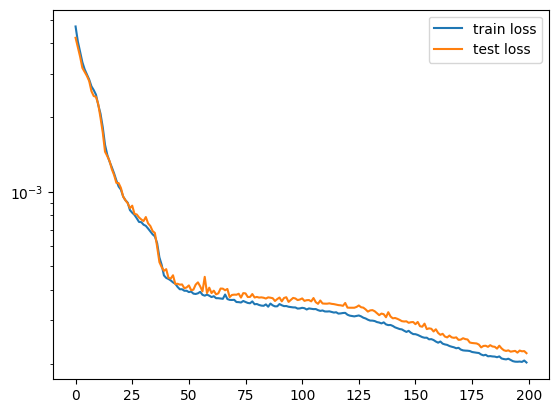

In [21]:
fig,ax=plt.subplots(1,1)
ax.plot(train_losses,label="train loss")
ax.plot(test_losses,label="test loss")
ax.set_yscale("log")
ax.legend()
plt.show()

R2: 0.994, mse: 2.22e-04


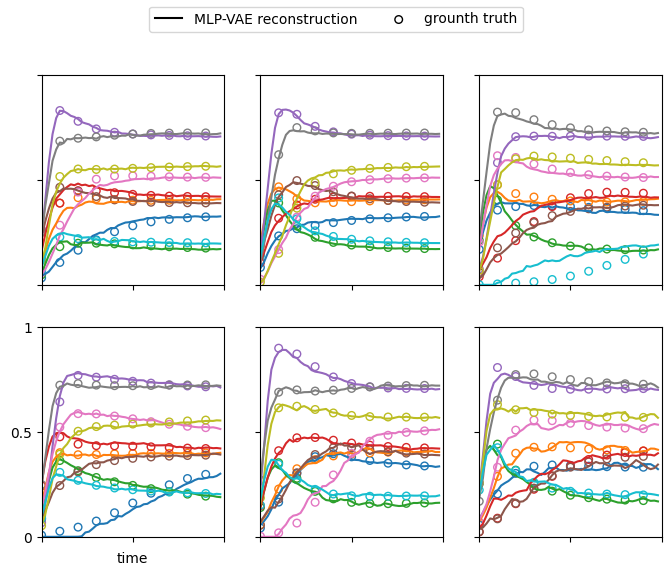

In [22]:
mlpvae.eval()
iv = X_test.X
curves = X_test.Y
with torch.no_grad():
    pred = mlpvae(iv.to(device)).cpu()
    loss = F.mse_loss(pred, curves).item()
r2 = r2_score(curves.flatten(),pred.flatten())
print(f"R2: {r2:.3f}, mse: {loss:.2e}")


fig,axes=plt.subplots(2,3,figsize=(8,6))
axes=axes.flat

n_show=6
tp_show=np.arange(0,50,5)
np.random.seed(42)
idx_show = np.random.choice(np.arange(curves.shape[0]),n_show,replace=False)

x=np.arange(0,50,1)
for i,ii in enumerate(idx_show):
    ax=axes[i]
    data=curves[ii]
    rec=pred[ii]
    for k in range(n_target):
        l=ax.plot(x,rec[k,:],linewidth=1.5)
        ax.scatter(x[tp_show],data[k,tp_show],s=30,edgecolor=l[-1].get_color(),facecolor="None")
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0,50])
        ax.set_xticks([0,25,50])
        ax.set_xticklabels([])
        ax.set_yticks([0,0.5,1])
        ax.set_yticklabels([])
    ax.set_ylim([0,1])
ax=axes[3]
ax.set_xticklabels([])
ax.set_xlabel("time")
ax.set_yticklabels([0,0.5,1])
ax.plot([],[],c="k",linewidth=1.5,label="MLP-VAE reconstruction")
ax.scatter([],[],s=30,edgecolor="k",facecolor="None",label="grounth truth")
fig.legend(loc="upper center",ncol=2)

## After training: data analysis
**code below this point requires downloading the entire dataset from Zenodo.**

In [8]:
def get_reconstruction(model_index, n_target, trial):
    
    n_ori=10
    n_background=n_ori-n_target
    
    Ec_data = np.loadtxt(f"./saved_data/bgLV/Ec_bgLV_model{model_index}_random.txt")
    N_TG = Ec_data[0,:]
    Ec = Ec_data[1,:]
    k = np.where(N_TG==n_target)[0][0]
    n_embedding = int(np.ceil(Ec[k]))
    vae_model = VAE(n_target, n_embedding)
    vae_model.to("cuda:0");
    vae_model.load_state_dict(
        torch.load(
            "./vae_models/bgLV/I%i/random_B%i_T%i_E%i_retrain.pth"
            % (model_index, n_background, n_target, n_embedding), weights_only=True)
    )
    vae_model.eval()

    mlpvae = MLP_VAE(vae_model, n_embedding, n_ori)
    mlpvae.to("cuda:0");
    mlpvae.load_state_dict(
        torch.load(
            "./mlp_models/bgLV/I%i/MLP_T%i_E%i_trial%i.pth"
            % (model_index, n_target, n_embedding, trial), weights_only=True)
    )
    mlpvae.eval()

    train_data, test_data = get_data(model_index,n_ori,n_target)
    ivs_test = test_data.X
    curves_test = test_data.Y
    
    with torch.no_grad():
        VAE_rec,_,_,_ = vae_model(curves_test.to("cuda:0"))
        VAE_rec = VAE_rec.cpu()

        MLP_rec = mlpvae(ivs_test.to("cuda:0")).cpu()

    curves_test_np = curves_test.numpy()
    VAE_rec_np = VAE_rec.numpy()
    MLP_rec_np = MLP_rec.numpy()
    
    return curves_test_np,VAE_rec_np,MLP_rec_np
        
        

VAE R2: 0.994, VAE-MLP R2: 0.991


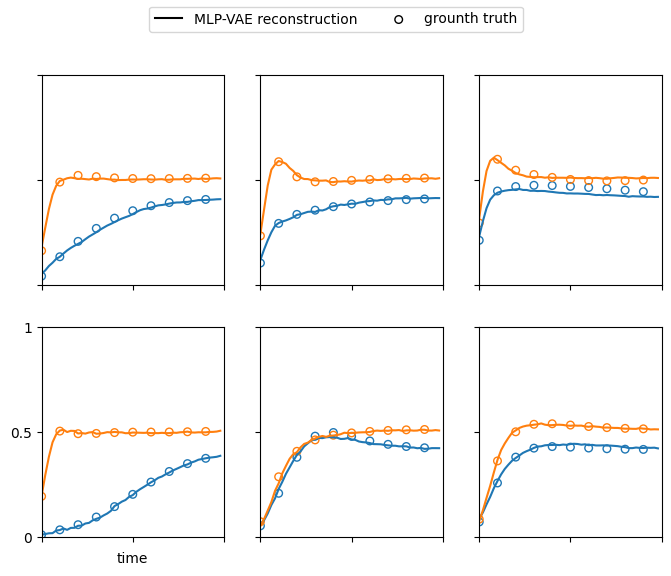

In [28]:
model_index = 4
n_target = 2
trial = 2
ground_truth, VAE_rec, MLP_rec = get_reconstruction(model_index, n_target, trial)
r2_VAE = r2_score(ground_truth.flatten(),VAE_rec.flatten())
r2_MLP = r2_score(ground_truth.flatten(),MLP_rec.flatten())
print(f"VAE R2: {r2_VAE:.3f}, VAE-MLP R2: {r2_MLP:.3f}")
fig,axes=plt.subplots(2,3,figsize=(8,6))
axes=axes.flat

n_show=6
tp_show=np.arange(0,50,5)
np.random.seed(42)
idx_show = np.random.choice(np.arange(ground_truth.shape[0]),n_show,replace=False)

x=np.arange(0,50,1)
for i,ii in enumerate(idx_show):
    ax=axes[i]
    data=ground_truth[ii]
    rec=MLP_rec[ii]
    for k in range(n_target):
        l=ax.plot(x,rec[k,:],linewidth=1.5)
        ax.scatter(x[tp_show],data[k,tp_show],s=30,edgecolor=l[-1].get_color(),facecolor="None")
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0,50])
        ax.set_xticks([0,25,50])
        ax.set_xticklabels([])
        ax.set_yticks([0,0.5,1])
        ax.set_yticklabels([])
    ax.set_ylim([0,1])
ax=axes[3]
ax.set_xticklabels([])
ax.set_xlabel("time")
ax.set_yticklabels([0,0.5,1])
ax.plot([],[],c="k",linewidth=1.5,label="MLP-VAE reconstruction")
ax.scatter([],[],s=30,edgecolor="k",facecolor="None",label="grounth truth")
fig.legend(loc="upper center",ncol=2)

In [11]:
model_index = 4
R2_all = np.zeros((5,5,2)) # 1st dim: n_target; 2nd dim: 5 trials; 3rd dim: VAE / VAE-MLP reconstruction
N_TG = np.array([2,3,5,8,10])
for i,n_target in enumerate(N_TG):
    for j,trial in enumerate(np.arange(1,6,1)):
        ground_truth, VAE_rec, MLP_rec = get_reconstruction(model_index, n_target, trial)
        if j==0:
            np.save(f"./mlpvae_reconstruction/I{model_index}_T{n_target}_ground_truth.npy",ground_truth)
            np.save(f"./mlpvae_reconstruction/I{model_index}_T{n_target}_MLP_rec_trial{trial}.npy",MLP_rec)
        r2_VAE = r2_score(ground_truth.flatten(),VAE_rec.flatten())
        r2_MLP = r2_score(ground_truth.flatten(),MLP_rec.flatten())
        R2_all[i,j,0] = r2_VAE
        R2_all[i,j,1] = r2_MLP
np.save(f"./mlpvae_reconstruction/I{model_index}_R2.npy",R2_all)

# 100-member community
For the 100-member community, we used a more complex MLP model to accommodate the more complex shapes in the observable time series.

In [6]:
class MLP_VAE(torch.nn.Module):
    
    def __init__(self, VAE, n_embedding, N):
        super().__init__()
        
        self.channels = 128
        
        self.mlp = nn.Sequential(
            nn.Linear(N,self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels,self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels,self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels,n_embedding),
            nn.LeakyReLU(),
        )

        self.fc_decoder = VAE.fc_decoder.eval()
        self.decoder = VAE.decoder.eval()
        
        # Freeze the parameters of the VAE
        for param in self.fc_decoder.parameters():
            param.requires_grad = False
        for param in self.decoder.parameters():
            param.requires_grad = False
        
    
    def forward(self, X):

        B = X.shape[0]
        C = 32
        L = 50
        
        code = self.mlp(X)
        
        # Pass through FC layers before decoding
        post_code = self.fc_decoder(code)

        X_hat = self.decoder(post_code.view(B, C, L))

        return X_hat


In [7]:
def get_data_100K(model_index,n_ori,n_target):
    n_background=n_ori-n_target

    X_train = np.load("./saved_sims/bgLV/I%i/bgLV_random_init_train_100K.npy"
                               % (model_index))
    X_test = np.load("./saved_sims/bgLV/I%i/bgLV_random_init_test_100K.npy"
                               % (model_index))
    X_train = torch.Tensor(X_train).float()*5
    X_test = torch.Tensor(X_test).float()*5
    
    
    y_train = np.load("./saved_sims/bgLV/I%i/bgLV_B%i_T%i_random_train_100K.npy"
                               % (model_index, n_background, n_target))
    y_test = np.load("./saved_sims/bgLV/I%i/bgLV_B%i_T%i_random_test_100K.npy"
                               % (model_index, n_background, n_target))

    y_train = torch.Tensor(y_train).float()
    y_test = torch.Tensor(y_test).float()

    data_train = IVCurveDataSet(X_train, y_train)
    data_test = IVCurveDataSet(X_test, y_test)

    return data_train, data_test

In [41]:
sim_type="random"
model_index=1
n_ori=100
n_target=10
n_background=n_ori-n_target


Ec_data = np.loadtxt(f"./saved_data/bgLV/Ec_bgLV_model{model_index}_{sim_type}.txt")
N_TG = Ec_data[0,:]
Ec = Ec_data[1,:]
k = np.where(N_TG==n_target)[0][0]
n_embedding = int(np.ceil(Ec[k]))
data=np.loadtxt("./saved_data/bgLV/I%i/reconstruction_B%i_T%i_bgLV_random_test.txt"%
               (model_index,n_background,n_target))
print(f"{int(n_target)}-target Ec = {Ec[k]:.1f}, round up to {n_embedding}")

X_train,X_test = get_data_100K(model_index,n_ori,n_target)
print(X_train.X.shape)

10-target Ec = 22.2, round up to 23
torch.Size([80000, 100])


In [48]:
vae_model = VAE(n_target,n_embedding)
vae_model.to("cuda:0");
vae_model.load_state_dict(
    torch.load(
        "./vae_models/bgLV/I%i/%s_B%i_T%i_E%i_retrain.pth"
        % (model_index, sim_type, n_background, n_target, n_embedding),weights_only=True)
)
vae_model.eval()
batch = torch.Tensor(X_test.Y).float()
with torch.no_grad():
    reconstruction,_,mu,log_var = vae_model(batch.to("cuda:0"))
    reconstruction = reconstruction.cpu()
    mse = F.mse_loss(batch,reconstruction)
    r2 = r2_score(batch.flatten(), reconstruction.flatten())
FUV = (1-r2)*100
print(f"Retrained VAE reconstruction: MSE:{mse:.1e}, FUV:{FUV:.2f}%")

Retrained VAE reconstruction: MSE:3.4e-04, FUV:1.07%


In [49]:
import time as timer

t0=timer.perf_counter()

mlpvae = MLP_VAE(vae_model, n_embedding, n_ori)
mlpvae.to("cuda:0");
mlpvae.mlp.train()

train_loader = DataLoader(X_train,batch_size=64,shuffle=True)
test_loader = DataLoader(X_test,batch_size=64,shuffle=False)
train_losses=[]
test_losses=[]

EPOCHS=100
lr=2e-3
lr_decay=0.99
optimizer = torch.optim.Adam(mlpvae.mlp.parameters(), lr=lr)

for ix_epoch in trange(EPOCHS):
    train_err=train_model(mlpvae, train_loader, optimizer)
    test_err=test_model(mlpvae, test_loader)
    train_losses.append(train_err)
    test_losses.append(test_err)
    # Exponential decay for learning rate
    lr *= lr_decay
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
print("Train Finished\n---------")
print("train loss = %1.2e, test loss = %1.2e"%(train_err,test_err))
train_time=timer.perf_counter()-t0
print("training finished, time used: %i s"%train_time)

  0%|          | 0/100 [00:00<?, ?it/s]

Train Finished
---------
train loss = 8.64e-04, test loss = 8.90e-04
training finished, time used: 357 s


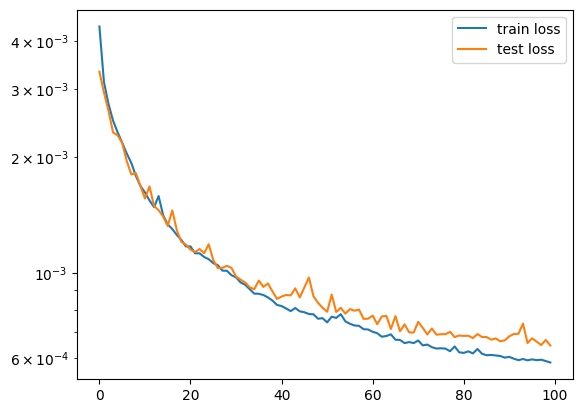

In [39]:
fig,ax=plt.subplots(1,1)
ax.plot(train_losses,label="train loss")
ax.plot(test_losses,label="test loss")
ax.set_yscale("log")
ax.legend()
plt.show()

48919
R2: 0.980, mse: 6.48e-04


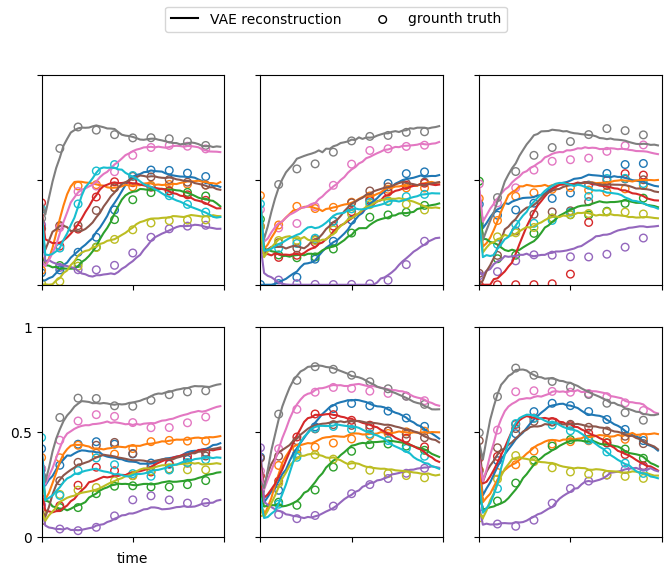

In [40]:
mlpvae.eval()
print(count_parameters(mlpvae))
iv = X_test.X
curves = X_test.Y
with torch.no_grad():
    pred = mlpvae(iv.to(device)).cpu()
    loss = F.mse_loss(pred, curves).item()
r2 = r2_score(curves.flatten(),pred.flatten())
print(f"R2: {r2:.3f}, mse: {loss:.2e}")


fig,axes=plt.subplots(2,3,figsize=(8,6))
axes=axes.flat

n_show=6
tp_show=np.arange(0,50,5)
np.random.seed(21)
idx_show = np.random.choice(np.arange(curves.shape[0]),n_show,replace=False)

x=np.arange(0,50,1)
for i,ii in enumerate(idx_show):
    ax=axes[i]
    data=curves[ii]
    rec=pred[ii]
    for k in range(n_target):
        l=ax.plot(x,rec[k,:],linewidth=1.5)
        ax.scatter(x[tp_show],data[k,tp_show],s=30,edgecolor=l[-1].get_color(),facecolor="None")
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0,50])
        ax.set_xticks([0,25,50])
        ax.set_xticklabels([])
        ax.set_yticks([0,0.5,1])
        ax.set_yticklabels([])
    ax.set_ylim([0,1])
ax=axes[3]
ax.set_xticklabels([])
ax.set_xlabel("time")
ax.set_yticklabels([0,0.5,1])
ax.plot([],[],c="k",linewidth=1.5,label="VAE reconstruction")
ax.scatter([],[],s=30,edgecolor="k",facecolor="None",label="grounth truth")
fig.legend(loc="upper center",ncol=2)

### Data Analysis

In [8]:
def get_reconstruction(model_index, n_target, trial):
    
    n_ori=100
    n_background=n_ori-n_target
    
    Ec_data = np.loadtxt(f"./saved_data/bgLV/Ec_bgLV_model{model_index}_random.txt")
    N_TG = Ec_data[0,:]
    Ec = Ec_data[1,:]
    k = np.where(N_TG==n_target)[0][0]
    n_embedding = int(np.ceil(Ec[k]))
    vae_model = VAE(n_target, n_embedding)
    vae_model.to("cuda:0");
    vae_model.load_state_dict(
        torch.load(
            "./vae_models/bgLV/I%i/random_B%i_T%i_E%i_retrain.pth"
            % (model_index, n_background, n_target, n_embedding), weights_only=True)
    )
    vae_model.eval()

    mlpvae = MLP_VAE(vae_model, n_embedding, n_ori)
    mlpvae.to("cuda:0");
    mlpvae.load_state_dict(
        torch.load(
            "./mlp_models/bgLV/I%i/MLP_T%i_E%i_trial%i.pth"
            % (model_index, n_target, n_embedding, trial), weights_only=True)
    )
    mlpvae.eval()

    train_data, test_data = get_data_100K(model_index,n_ori,n_target)
    ivs_test = test_data.X
    curves_test = test_data.Y
    
    with torch.no_grad():
        VAE_rec,_,_,_ = vae_model(curves_test.to("cuda:0"))
        VAE_rec = VAE_rec.cpu()

        MLP_rec = mlpvae(ivs_test.to("cuda:0")).cpu()

    curves_test_np = curves_test.numpy()
    VAE_rec_np = VAE_rec.numpy()
    MLP_rec_np = MLP_rec.numpy()
    
    return curves_test_np,VAE_rec_np,MLP_rec_np
        
        

VAE R2: 0.990, VAE-MLP R2: 0.973


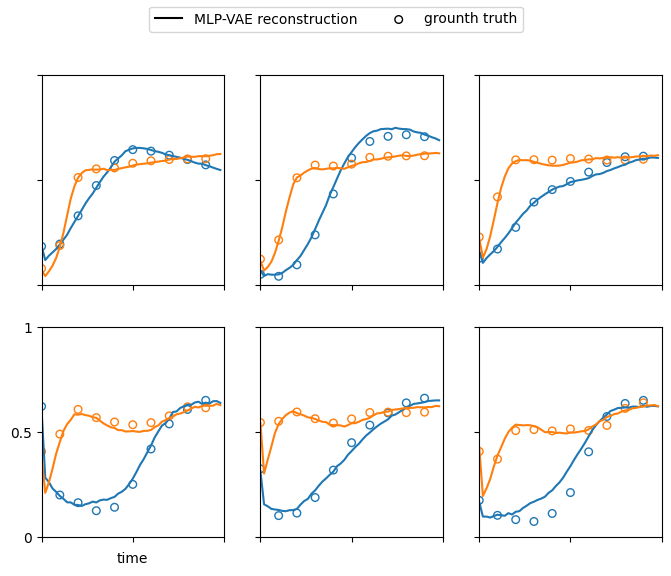

In [10]:
model_index = 1
n_target = 2
trial = 1
ground_truth, VAE_rec, MLP_rec = get_reconstruction(model_index, n_target, trial)
r2_VAE = r2_score(ground_truth.flatten(),VAE_rec.flatten())
r2_MLP = r2_score(ground_truth.flatten(),MLP_rec.flatten())
print(f"VAE R2: {r2_VAE:.3f}, VAE-MLP R2: {r2_MLP:.3f}")
fig,axes=plt.subplots(2,3,figsize=(8,6))
axes=axes.flat

n_show=6
tp_show=np.arange(0,50,5)
np.random.seed(42)
idx_show = np.random.choice(np.arange(ground_truth.shape[0]),n_show,replace=False)

x=np.arange(0,50,1)
for i,ii in enumerate(idx_show):
    ax=axes[i]
    data=ground_truth[ii]
    rec=MLP_rec[ii]
    for k in range(n_target):
        l=ax.plot(x,rec[k,:],linewidth=1.5)
        ax.scatter(x[tp_show],data[k,tp_show],s=30,edgecolor=l[-1].get_color(),facecolor="None")
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0,50])
        ax.set_xticks([0,25,50])
        ax.set_xticklabels([])
        ax.set_yticks([0,0.5,1])
        ax.set_yticklabels([])
    ax.set_ylim([0,1])
ax=axes[3]
ax.set_xticklabels([])
ax.set_xlabel("time")
ax.set_yticklabels([0,0.5,1])
ax.plot([],[],c="k",linewidth=1.5,label="MLP-VAE reconstruction")
ax.scatter([],[],s=30,edgecolor="k",facecolor="None",label="grounth truth")
fig.legend(loc="upper center",ncol=2)

In [13]:
model_index = 1
R2_all = np.zeros((5,5,2)) # 1st dim: n_target; 2nd dim: 5 trials; 3rd dim: VAE / VAE-MLP reconstruction
N_TG = np.array([2,3,5,8,10])
for i,n_target in enumerate(N_TG):
    for j,trial in enumerate(np.arange(1,6,1)):
        ground_truth, VAE_rec, MLP_rec = get_reconstruction(model_index, n_target, trial)
        if j==0:
            np.save(f"./mlpvae_reconstruction/I{model_index}_T{n_target}_ground_truth.npy",ground_truth)
            np.save(f"./mlpvae_reconstruction/I{model_index}_T{n_target}_MLP_rec_trial{trial}.npy",MLP_rec)
        r2_VAE = r2_score(ground_truth.flatten(),VAE_rec.flatten())
        r2_MLP = r2_score(ground_truth.flatten(),MLP_rec.flatten())
        R2_all[i,j,0] = r2_VAE
        R2_all[i,j,1] = r2_MLP
np.save(f"./mlpvae_reconstruction/I{model_index}_R2.npy",R2_all)